# Lightweight Fine-Tuning Project

TODO: In this cell, describe your choices for each of the following

* PEFT technique: 
* Model: 
* Evaluation approach: 
* Fine-tuning dataset: 

## Loading and Evaluating a Foundation Model

TODO: In the cells below, load your chosen pre-trained Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

In [1]:
# ModernBERT blog: https://www.answer.ai/posts/2024-12-19-modernbert.html
# Philipp Schmid's blog on Fine-Tuning open LLMs: https://www.philschmid.de/fine-tune-llms-in-2025

# https://learn.udacity.com/nanodegrees/nd101-ent-ai-swe-indeed/parts/cd13303/lessons/786df5de-95ad-4e0d-be51-cc8a1c1e40fe/concepts/ed4cd691-b999-454e-b715-a603fb2aeeb5?lesson_tab=lesson
from peft import LoraConfig
config = LoraConfig()
# https://huggingface.co/docs/peft/main/en/conceptual_guides/lora

In [1]:
import torch
# This is to improve performance on M1 Macs
def get_best_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_best_device()

from datasets import load_dataset

sms_spam_dataset = load_dataset("sms_spam", split=["train"])[0]

# Split the dataset into train and test sets (assuming `dataset` is a Hugging Face Dataset object)
sms_spam_dataset_train_test_split = sms_spam_dataset.train_test_split(test_size=0.2, seed=42)
test_dataset = sms_spam_dataset_train_test_split['test']

#print(sms_spam_dataset[:5])

"""
Convert the dataset to a pandas DataFrame
"""
import pandas as pd

# Convert the entire dataset to a pandas DataFrame
df = pd.DataFrame(sms_spam_dataset)
# Display the first 10 rows
print(df.head(10))

# Or for more detailed information
display(df.head(10))  # Works in Jupyter notebooks


# for entry in dataset.select(range(3)):
#     sms = entry["sms"]
#     label = entry["label"]
#     print(f"label={label}, sms={sms}")


                                                 sms  label
0  Go until jurong point, crazy.. Available only ...      0
1                    Ok lar... Joking wif u oni...\n      0
2  Free entry in 2 a wkly comp to win FA Cup fina...      1
3  U dun say so early hor... U c already then say...      0
4  Nah I don't think he goes to usf, he lives aro...      0
5  FreeMsg Hey there darling it's been 3 week's n...      1
6  Even my brother is not like to speak with me. ...      0
7  As per your request 'Melle Melle (Oru Minnamin...      0
8  WINNER!! As a valued network customer you have...      1
9  Had your mobile 11 months or more? U R entitle...      1


,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
5,FreeMsg Hey there darling it's been 3 week's n...,1
6,Even my brother is not like to speak with me. ...,0
7,As per your request 'Melle Melle (Oru Minnamin...,0
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[101, 2045, 2003, 2053, 7189, 2012, 2035, 2090, 3481, 3771, 1998, 6337, 2099, 2021, 1996, 2755, 2008, 2119, 2024, 2610, 2186, 2055, 6355, 6997, 1012, 6337, 2099, 3504, 15594, 2100, 1010, 3481, 3771, 3504, 4438, 1012, 6337, 2099, 14811, 2024, 3243, 3722, 1012, 3481, 3771, 1005, 1055, 5436, 2024, 2521, 2062, 8552, 1012, 1012, 1012, 3481, 3771, 3504, 2062, 2066, 3539, 8343, 1010, 2065, 2057, 2031, 2000, 3962, 12319, 1012, 1012, 1012, 1996, 2364, 2839, 2003, 5410, 1998, 6881, 2080, 1010, 2021, 2031, 1000, 17936, 6767, 7054, 3401, 1000, 1012, 2111, 2066, 2000, 12826, 1010, 2000, 3648, 1010, 2000, 16157, 1012, 2129, 2055, 2074, 9107, 1029, 6057, 2518, 2205, 1010, 2111, 3015, 3481, 3771, 3504, 2137, 2021, 1010, 2006, 1996, 2060, 2192, 1010, 9177, 2027, 9544, 2137, 2186, 1006, 999, 999, 999, 1007, 1012, 2672, 2009, 1005, 1055, 1996, 2653, 1010, 2030, 1996, 4382, 1010, 2021, 1045, 2228, 2023, 2186, 2003, 2062, 2394, 2084, 2137, 1012, 2011, 1996, 2126, 1010, 1996, 5889, 2024, 2428, 2204, 1998, 6

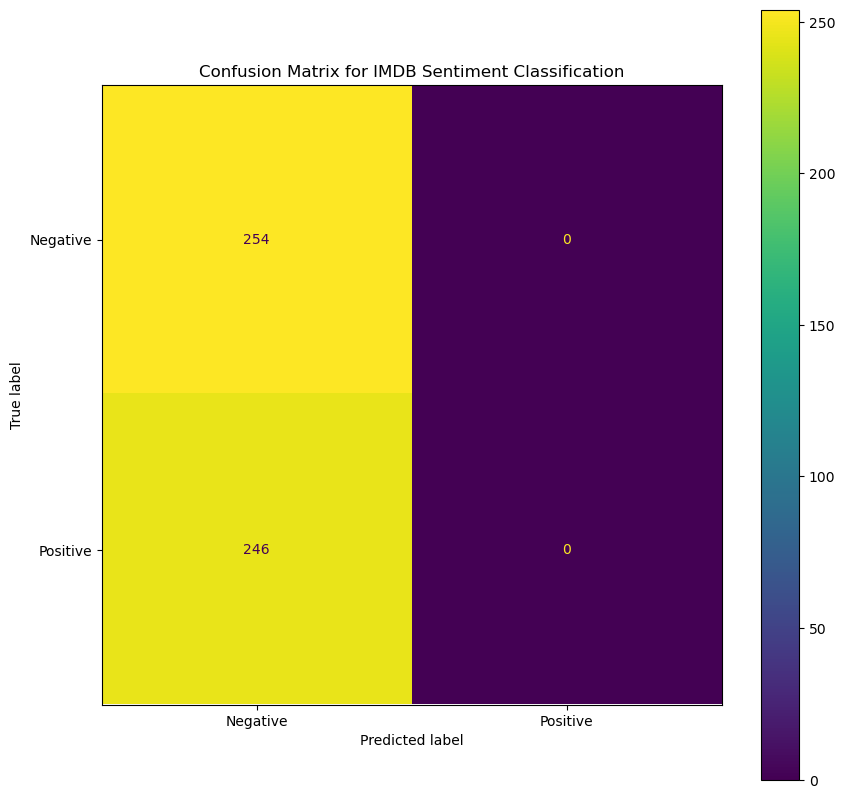

In [3]:
"""
My own version
"""
from sklearn.metrics import accuracy_score
# Load the train and test splits of the imdb dataset
splits = ["train", "test"]
ds_imdb = {split: ds for split, ds in zip(splits, load_dataset("imdb", split=splits))}

# Thin out the dataset to make it run faster for this example
for split in splits:
    ds_imdb[split] = ds_imdb[split].shuffle(seed=42).select(range(500))


#Tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    """Preprocess the imdb dataset by returning tokenized examples."""
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_ds = {}
for split in splits:
    tokenized_ds[split] = ds_imdb[split].map(preprocess_function, batched=True)

tokenized_test = ds_imdb["test"].map(preprocess_function, batched=True)

# Check that we tokenized the examples properly
assert tokenized_ds["train"][0]["input_ids"][:5] == [101, 2045, 2003, 2053, 7189]

# Show the first example of the tokenized training set
print(tokenized_ds["train"][0]["input_ids"])


#Models
# Very good documentation  https://huggingface.co/transformers/v4.2.2/training.html

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},  # For converting predictions to strings
    label2id={"NEGATIVE": 0, "POSITIVE": 1},
)

# Make predictions
predictions = []
true_labels = []

with torch.no_grad():
    for i in range(len(tokenized_test)):
        inputs = {
            "input_ids": torch.tensor(tokenized_test[i]["input_ids"]).unsqueeze(0),
            "attention_mask": torch.tensor(tokenized_test[i]["attention_mask"]).unsqueeze(0),
        }
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()
        predictions.append(predicted_label)
        true_labels.append(tokenized_test[i]["label"])

# Evaluate the predictions
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
labels = ["Negative", "Positive"]  # IMDB sentiment labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title("Confusion Matrix for IMDB Sentiment Classification")
plt.show()

In [15]:
# These are just tests to see if I can get the model to work
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Ensure the model is in evaluation mode
model.eval()

# Tokenize the test data
def tokenize_function(examples):
    return tokenizer(examples['sms'], padding=True, truncation=True, return_tensors="pt")

tokenized_test = test_dataset.map(tokenize_function, batched=True)


# Make predictions
predictions = []
true_labels = []

with torch.no_grad():
    for i in range(len(tokenized_test)):
        inputs = {
            "input_ids": torch.tensor(tokenized_test[i]["input_ids"]).unsqueeze(0),
            "attention_mask": torch.tensor(tokenized_test[i]["attention_mask"]).unsqueeze(0),
        }
        outputs = model(**inputs)
        logits = outputs.last_hidden_state.mean(dim=1)  # Simplified for classification
        predicted_label = torch.argmax(logits, dim=1).item()
        predictions.append(predicted_label)
        true_labels.append(test_dataset[i]["label"])

from sklearn.metrics import accuracy_score
# Evaluate the predictions
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")


inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
print(outputs)

Accuracy: 0.0
BaseModelOutput(last_hidden_state=tensor([[[-1.8296e-01, -7.4054e-02,  5.0267e-02,  ..., -1.1261e-01,
           4.4493e-01,  4.0941e-01],
         [ 7.0642e-04,  1.4825e-01,  3.4328e-01,  ..., -8.6040e-02,
           6.9475e-01,  4.3353e-02],
         [-5.0721e-01,  5.3085e-01,  3.7163e-01,  ..., -5.6288e-01,
           1.3756e-01,  2.8475e-01],
         ...,
         [-4.2251e-01,  5.7315e-02,  2.4338e-01,  ..., -1.5223e-01,
           2.4462e-01,  6.4155e-01],
         [-4.9384e-01, -1.8895e-01,  1.2641e-01,  ...,  6.3240e-02,
           3.6913e-01, -5.8252e-02],
         [ 8.3269e-01,  2.4948e-01, -4.5440e-01,  ...,  1.1998e-01,
          -3.9257e-01, -2.7785e-01]]], grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)


## Performing Parameter-Efficient Fine-Tuning

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.

###  ⚠️ IMPORTANT ⚠️

Due to workspace storage constraints, you should not store the model weights in the same directory but rather use `/tmp` to avoid workspace crashes which are irrecoverable.
Ensure you save it in /tmp always.

In [ ]:
# Saving the model
model.save("/tmp/your_model_name")

## Performing Inference with a PEFT Model

TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.